# Algoritmo

In [107]:
import numpy as np
import pandas as pd
import itertools as it

filename        = "Dataset_Covid_CE.csv"
k_values        = [2, 4, 8, 16]

def get_filename_out(k):
    return f"Dataset_Covid_CE_Anon_Sup_k{k}.csv"

def generate_csv(df, k):
    return df.to_csv(get_filename_out(k))

def is_k_anon(table, qt, k = 2):
    """
    para a tabela ser considerada k-anonima, todo elemento da tabela deve possuir pelo menos k outros elementos com a mesma combinaçao de semi-identificadores. ou seja, para k = 2 e qt = {Atr1, Atr2}, todo registro da tabela deve aparecer pelo menos 2 vezes com mesmo valor nos atributos "Atr1" e "Atr2".

    essa função agrupa os elementos da tabela pelos atributos semi-identificadores em qt e retorna False se algum grupo ocorre menos que k vezes, True se todo grupo ocorre ao menos k vezes.
    """

    groups = table.groupby(by=qt).size()
    for n_of_groups in groups:
        if n_of_groups < k: 
            return False
    return True

In [108]:
%%time
# limpeza

semi_id = [
    "municipioCaso",
    "sexoCaso",
    "dataNascimento",
    "resultadoFinalExame",
    "racaCor",
]

sensitive = [
    "comorbidadeCardiovascularSivep",
    "comorbidadeDiabetesSivep",
]

dtype = {
    "municipioCaso"                  : "str",
    "sexoCaso"                       : "str",
    "dataNascimento"                 : "str",
    "resultadoFinalExame"            : "str",
    "comorbidadeCardiovascularSivep" : "str",
    "comorbidadeDiabetesSivep"       : "str",
    "racaCor"                        : "str",
}

date_columns = [
    "dataNascimento",
]

date_parser = lambda x: pd.to_datetime(x, format="%Y-%m-%d", errors = 'coerce')

# pegar apenas os atributos desejados
# df = pd.read_csv(filename, usecols=semi_id + sensitive, dtype=dtype, parse_dates=date_columns, date_parser=date_parser)
df = pd.read_csv(filename, usecols=semi_id + sensitive, dtype=dtype)
df = df.dropna(how="all") # remover registros com todos os valores nulo
df = df.fillna("*") # padroniza valores nulos
df

Wall time: 11.9 s
Parser   : 157 ms


,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
19,SOBRAL,MASCULINO,2003-08-14,Negativo,*,*,Parda
20,PACAJUS,MASCULINO,1983-11-07,Negativo,*,*,Parda
21,HORIZONTE,FEMININO,1982-01-14,Negativo,*,*,*
25,FORTALEZA,MASCULINO,1992-03-12,Negativo,*,*,Parda
28,CAUCAIA,MASCULINO,1970-03-06,Negativo,*,*,Sem Informacao
...,...,...,...,...,...,...,...
1266272,FORTALEZA,FEMININO,1982-12-08,Positivo,*,*,Branca
1266273,FORTALEZA,FEMININO,1980-12-02,Negativo,*,*,Parda
1266274,FORTALEZA,FEMININO,1988-05-17,Provável,*,*,Branca
1266275,CRATEUS,FEMININO,1970-09-28,Negativo,*,*,Parda


In [109]:
# generate_csv(df, k=1)
is_k_anon(df, semi_id, k=2)

False

In [110]:
%%time
# 2. gerar tabela k = 2

k = 2
df2 = df

# remove os grupos k >= 2 já formados da tabela
df2 = df[df.duplicated(subset=semi_id, keep=False)]
need_supression = df.drop_duplicates(subset=semi_id, keep=False)

suppressed = [df2]

for n in [4, 3, 2, 1]:
    semi_id_combinations = it.combinations(semi_id, n)
    best_semi_id_combo = []
    duplicate_rows = []

    # para cada combinação de semi identificadores, checa quantos grupos k >= 2 formaria e pega a que gera mais
    for s in semi_id_combinations:
        rows = need_supression[need_supression.duplicated(subset=s, keep=False)]
        if len(duplicate_rows) < len(rows):
            duplicate_rows = rows.copy()
            best_semi_id_combo = s

    # pega o(s) atributo(s) que não aparece(m) na combinação e aplica supressão
    rm = list(set(semi_id) - set(best_semi_id_combo))
    for col in rm:
        duplicate_rows[col] = "*"

    # remove grupos recém formados da tabela original
    suppressed.append(duplicate_rows)
    need_supression = need_supression.drop_duplicates(subset=best_semi_id_combo, keep=False)

need_supression.dataNascimento = "*"
need_supression.racaCor = "*"
suppressed.append(need_supression)

df2 = pd.concat(suppressed).sort_index()
df2

Wall time: 8.91 s


,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
19,SOBRAL,MASCULINO,*,Negativo,*,*,Parda
20,PACAJUS,MASCULINO,1983-11-07,Negativo,*,*,Parda
21,HORIZONTE,FEMININO,*,Negativo,*,*,*
25,FORTALEZA,MASCULINO,1992-03-12,Negativo,*,*,Parda
28,CAUCAIA,MASCULINO,*,Negativo,*,*,Sem Informacao
...,...,...,...,...,...,...,...
1266272,FORTALEZA,FEMININO,*,Positivo,*,*,Branca
1266273,FORTALEZA,FEMININO,1980-12-02,Negativo,*,*,Parda
1266274,FORTALEZA,FEMININO,*,Provável,*,*,Branca
1266275,CRATEUS,FEMININO,1970-09-28,Negativo,*,*,Parda


In [111]:
# generate_csv(df2, k=2)
is_k_anon(df2, semi_id, k=2)

True

In [112]:
%%time
# 3. gerar tabela k = 4

k = 4
df4 = df2

need_supression = []
for name, group in df4.groupby(semi_id):
    if group.shape[0] < k:
        need_supression.append(group)

need_supression = pd.concat(need_supression).sort_index()
df4 = df4.drop(need_supression.index)

suppressed = [df4]

for n in [4, 3, 2, 1]:
    semi_id_combinations = it.combinations(semi_id, n)
    trows = []

    for s in semi_id_combinations:
        groups = need_supression.groupby(list(s))
        rows = []

        for name, group in groups:
            if group.shape[0] >= k:
                rm = list(set(semi_id) - set(s))
                for col in rm:
                    group[col] = "*"
                rows.append(group)

        if rows:
            rows = pd.concat(rows).sort_index()
            trows.append(rows)
            need_supression = need_supression.drop(rows.index)

    if trows:
        trows = pd.concat(trows).sort_index()
        suppressed.append(trows)

need_supression.dataNascimento = "*"
need_supression.racaCor = "*"
suppressed.append(need_supression)

df4 = pd.concat(suppressed).sort_index()
df4

Wall time: 1min 18s


,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
19,SOBRAL,MASCULINO,*,Negativo,*,*,Parda
20,PACAJUS,MASCULINO,*,Negativo,*,*,Parda
21,HORIZONTE,FEMININO,*,Negativo,*,*,*
25,FORTALEZA,MASCULINO,1992-03-12,Negativo,*,*,*
28,CAUCAIA,MASCULINO,*,Negativo,*,*,Sem Informacao
...,...,...,...,...,...,...,...
1266272,FORTALEZA,FEMININO,*,Positivo,*,*,Branca
1266273,FORTALEZA,FEMININO,1980-12-02,*,*,*,Parda
1266274,FORTALEZA,FEMININO,*,Provável,*,*,Branca
1266275,CRATEUS,FEMININO,1970-09-28,Negativo,*,*,Parda


In [113]:
# generate_csv(df4, k=4)
is_k_anon(df4, semi_id, k=4)

True

In [114]:
%%time
# 3. gerar tabela k = 8

k = 8
df8 = df4

need_supression = []
for name, group in df8.groupby(semi_id):
    if group.shape[0] < k:
        need_supression.append(group)

need_supression = pd.concat(need_supression).sort_index()
df8 = df8.drop(need_supression.index)

suppressed = [df8]

for n in [4, 3, 2, 1]:
    semi_id_combinations = it.combinations(semi_id, n)
    trows = []

    for s in semi_id_combinations:
        groups = need_supression.groupby(list(s))
        rows = []

        for name, group in groups:
            if group.shape[0] >= k:
                rm = list(set(semi_id) - set(s))
                for col in rm:
                    group[col] = "*"
                rows.append(group)

        if rows:
            rows = pd.concat(rows).sort_index()
            trows.append(rows)
            need_supression = need_supression.drop(rows.index)

    if trows:
        trows = pd.concat(trows).sort_index()
        suppressed.append(trows)

need_supression.dataNascimento = "*"
need_supression.racaCor = "*"
suppressed.append(need_supression)

df8 = pd.concat(suppressed).sort_index()
df8

Wall time: 17 s


,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
19,SOBRAL,MASCULINO,*,Negativo,*,*,Parda
20,PACAJUS,MASCULINO,*,Negativo,*,*,Parda
21,HORIZONTE,FEMININO,*,Negativo,*,*,*
25,FORTALEZA,MASCULINO,1992-03-12,Negativo,*,*,*
28,CAUCAIA,MASCULINO,*,Negativo,*,*,Sem Informacao
...,...,...,...,...,...,...,...
1266272,FORTALEZA,FEMININO,*,Positivo,*,*,Branca
1266273,FORTALEZA,FEMININO,*,*,*,*,Parda
1266274,FORTALEZA,FEMININO,*,Provável,*,*,Branca
1266275,CRATEUS,FEMININO,*,Negativo,*,*,Parda


In [115]:
# generate_csv(df8, k=8)
is_k_anon(df8, semi_id, k=8)

True

In [116]:
%%time
# 3. gerar tabela k = 16

k = 16
df16 = df8

need_supression = []
for name, group in df16.groupby(semi_id):
    if group.shape[0] < k:
        need_supression.append(group)

need_supression = pd.concat(need_supression).sort_index()
df16 = df16.drop(need_supression.index)

suppressed = [df16]

for n in [4, 3, 2, 1]:
    semi_id_combinations = it.combinations(semi_id, n)
    trows = []

    for s in semi_id_combinations:
        groups = need_supression.groupby(list(s))
        rows = []

        for name, group in groups:
            if group.shape[0] >= k:
                rm = list(set(semi_id) - set(s))
                for col in rm:
                    group[col] = "*"
                rows.append(group)

        if rows:
            rows = pd.concat(rows).sort_index()
            trows.append(rows)
            need_supression = need_supression.drop(rows.index)

    if trows:
        trows = pd.concat(trows).sort_index()
        suppressed.append(trows)

need_supression.dataNascimento = "*"
need_supression.racaCor = "*"
suppressed.append(need_supression)

df16 = pd.concat(suppressed).sort_index()
df16

Wall time: 7.56 s


,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
19,SOBRAL,MASCULINO,*,Negativo,*,*,Parda
20,PACAJUS,MASCULINO,*,Negativo,*,*,Parda
21,HORIZONTE,FEMININO,*,Negativo,*,*,*
25,FORTALEZA,MASCULINO,*,Negativo,*,*,*
28,CAUCAIA,MASCULINO,*,Negativo,*,*,Sem Informacao
...,...,...,...,...,...,...,...
1266272,FORTALEZA,FEMININO,*,Positivo,*,*,Branca
1266273,FORTALEZA,FEMININO,*,*,*,*,Parda
1266274,FORTALEZA,FEMININO,*,Provável,*,*,Branca
1266275,CRATEUS,FEMININO,*,Negativo,*,*,Parda


In [117]:
# generate_csv(df16, k=16)
is_k_anon(df16, semi_id, k=16)

True

# Gráficos

In [118]:
import matplotlib.pyplot as plt

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

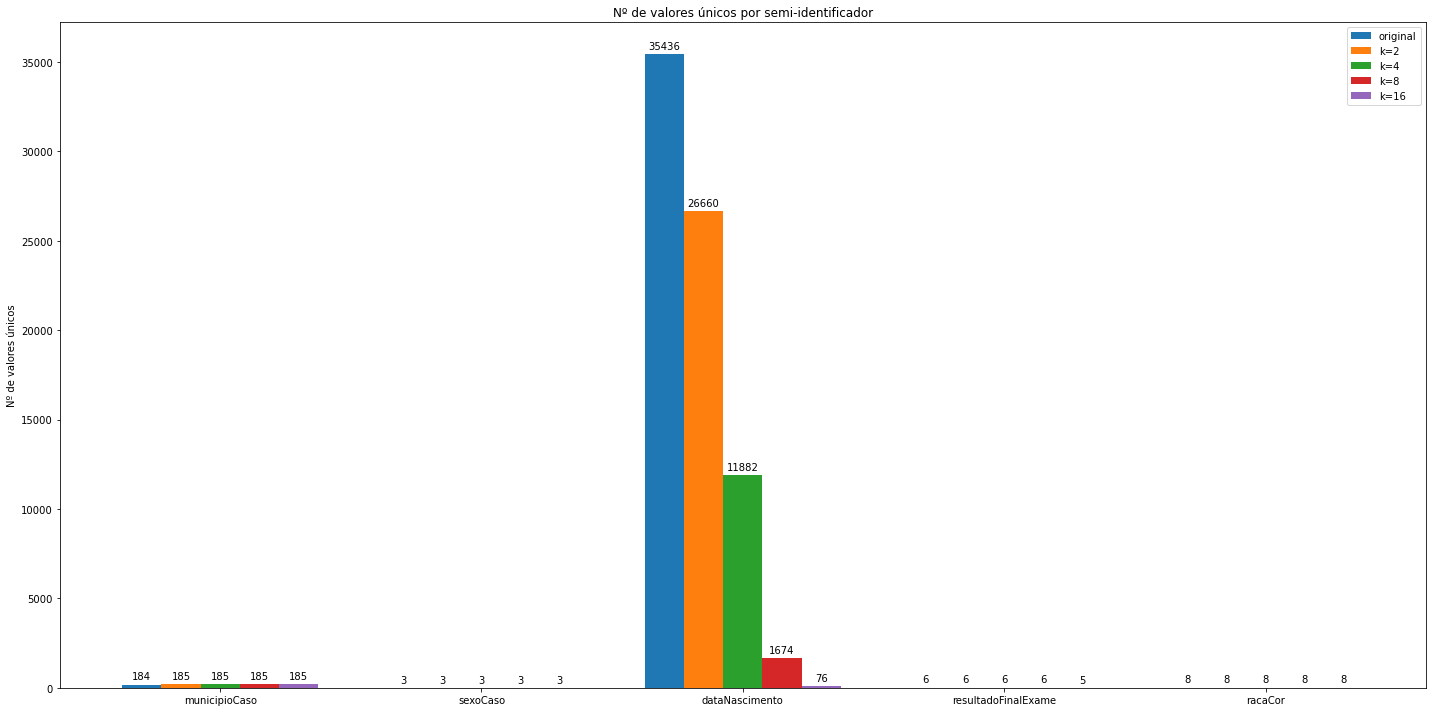

In [119]:
labels = semi_id
d   = dict(df[semi_id].nunique())
d2  = dict(df2[semi_id].nunique())
d4  = dict(df4[semi_id].nunique())
d8  = dict(df8[semi_id].nunique())
d16 = dict(df16[semi_id].nunique())

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width*2, d.values(), width, label='original')
rects2 = ax.bar(x - width, d2.values(), width, label='k=2')
rects3 = ax.bar(x, d4.values(), width, label='k=4')
rects4 = ax.bar(x + width, d8.values(), width, label='k=8')
rects5 = ax.bar(x + width*2, d16.values(), width, label='k=16')

ax.set_title('Nº de valores únicos por semi-identificador')
ax.set_ylabel('Nº de valores únicos')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()
fig.savefig('uniq_semi_id')
plt.show()

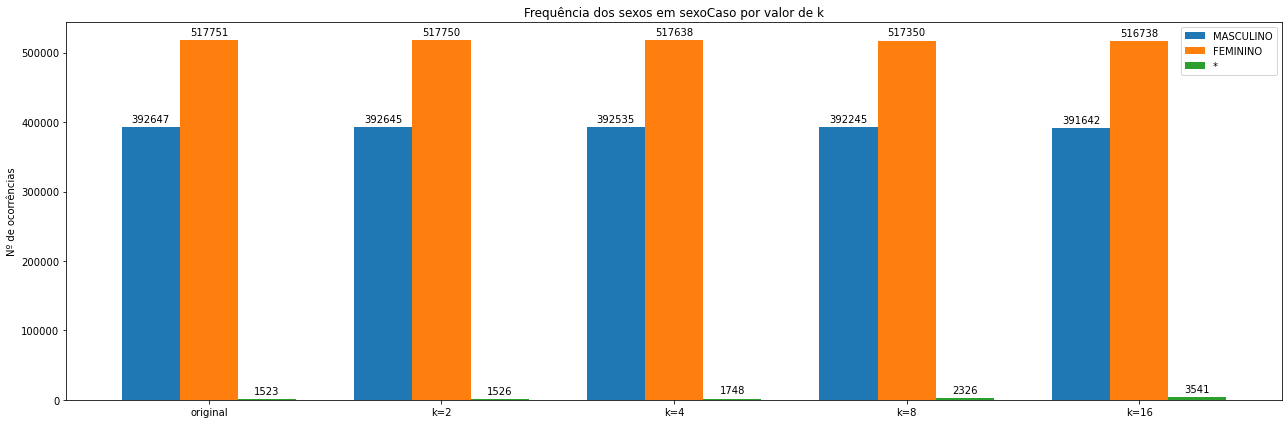

In [120]:
dfs = [df, df2, df4, df8, df16]

m  = [t['sexoCaso'].value_counts()['MASCULINO'] for t in dfs]
f  = [t['sexoCaso'].value_counts()['FEMININO'] for t in dfs]
na = [t['sexoCaso'].value_counts()['*'] for t in dfs]

labels = ['original', 'k=2', 'k=4', 'k=8', 'k=16']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 6))
rects1 = ax.bar(x - width, m, width, label='MASCULINO')
rects2 = ax.bar(x, f, width, label='FEMININO')
rects3 = ax.bar(x + width, na, width, label='*')

ax.set_title('Frequência dos sexos em sexoCaso por valor de k')
ax.set_ylabel('Nº de ocorrências')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.savefig('freq_sexoCaso')
plt.show()

[1893645, 2545319, 2753792, 2843033, 2872217]


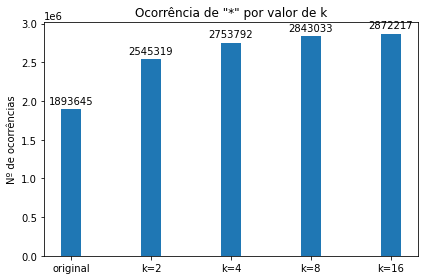

In [121]:
labels = ['original', 'k=2', 'k=4', 'k=8', 'k=16']
y  = [t.stack().value_counts()['*'] for t in dfs]
x = np.arange(len(labels))
width = 0.25

print(y)

fig, ax = plt.subplots()
rects = ax.bar(x, y, width)

ax.set_title('Ocorrência de "*" por valor de k')
ax.set_ylabel('Nº de ocorrências')
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects)

fig.tight_layout()
fig.savefig('freq_supressed_or_null')
plt.show()

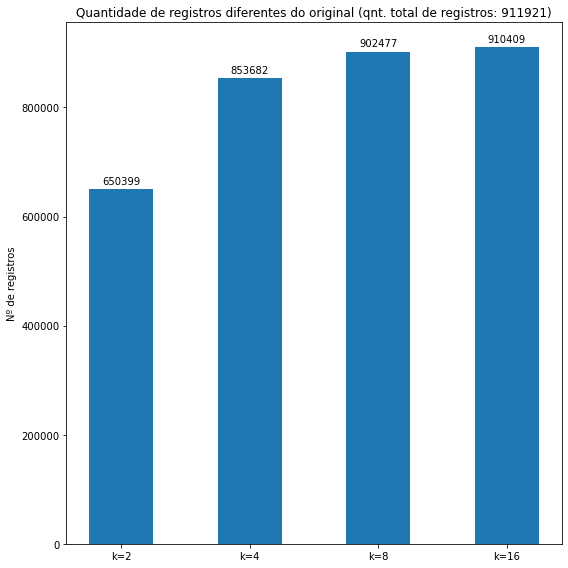

In [122]:
# diferença entre df e df2
dfx2  = df[~df.apply(tuple,1).isin(df2.apply(tuple,1))].shape[0]
dfx4  = df[~df.apply(tuple,1).isin(df4.apply(tuple,1))].shape[0]
dfx8  = df[~df.apply(tuple,1).isin(df8.apply(tuple,1))].shape[0]
dfx16 = df[~df.apply(tuple,1).isin(df16.apply(tuple,1))].shape[0]

labels = ['k=2', 'k=4', 'k=8', 'k=16']
y = [dfx2, dfx4, dfx8, dfx16]
x = np.arange(len(labels))
width = .5

fig, ax = plt.subplots(figsize=(8, 8))
rects = ax.bar(x, y, width)

ax.set_title(f'Quantidade de registros diferentes do original (qnt. total de registros: {df.shape[0]})')
ax.set_ylabel('Nº de registros')
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects)

fig.tight_layout()
fig.savefig('difference')
plt.show()

In [123]:
df.describe()

,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
count,911921,911921,911921,911921,911921,911921,911921
unique,184,3,35436,6,4,4,8
top,FORTALEZA,FEMININO,*,Negativo,*,*,Parda
freq,238374,517751,206,543568,902505,903015,482975


In [124]:
df2.describe()

,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
count,911921,911921,911921,911921,911921,911921,911921
unique,185,3,26660,6,4,4,8
top,FORTALEZA,FEMININO,*,Negativo,*,*,Parda
freq,238372,517750,650604,543564,902505,903015,482974


In [125]:
df4.describe()

,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
count,911921,911921,911921,911921,911921,911921,911921
unique,185,3,11882,6,4,4,8
top,FORTALEZA,FEMININO,*,Negativo,*,*,Parda
freq,238361,517638,819097,538009,902505,903015,472461


In [126]:
df8.describe()

,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
count,911921,911921,911921,911921,911921,911921,911921
unique,185,3,1674,6,4,4,8
top,FORTALEZA,FEMININO,*,Negativo,*,*,Parda
freq,238346,517350,894505,536409,902505,903015,470385


In [127]:
df16.describe()

,municipioCaso,sexoCaso,dataNascimento,resultadoFinalExame,comorbidadeCardiovascularSivep,comorbidadeDiabetesSivep,racaCor
count,911921,911921,911921,911921,911921,911921,911921
unique,185,3,76,5,4,4,8
top,FORTALEZA,FEMININO,*,Negativo,*,*,Parda
freq,238307,516738,910286,535886,902505,903015,469659


In [128]:
# %%time

# suprimir valores de cada semi-identificador que ocorrem < k vezes (pois não seria possível formar >= k grupos com eles)
# def supress_unique_k_values(table, qt, k = 2):
#     for col in qt:
#         to_replace = []
#         value_count = dict(table[col].value_counts(dropna=False))
#         for value in value_count:
#             if (value_count[value] < k):
#                 to_replace.append(value)
#         table[col] = table[col].replace(to_replace, "*")
#     return table

# df1 = supress_unique_k_values(df, semi_id, k=2)
# df1